# Taxi Travel Data Analysis

In this demo, we will be doing some demos on temporal feature engineering with the Kaggle Dataset

### Loading libraries, datasets

In [2]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torch

In [3]:
# These are all of the files you are given
#df_tr = pd.read_csv("archive/train.csv")


In [4]:
#df_tr.head()
# avg = df_tr['LEN'].mean()
# print(avg)

### Get Computed Time from POLYLINE

Our goal is to predict the travel-time of the taxi, which can be derived from the POLYLINE length.

Recall:

```
The travel time of the trip (the prediction target of this project) is defined as the (number of points-1) x 15 seconds. 
For example, a trip with 101 data points in POLYLINE has a length of (101-1) * 15 = 1500 seconds. Some trips have missing 
data points in POLYLINE, indicated by MISSING_DATA column, and it is part of the challenge how you utilize this knowledge.
```

We are not doing anything with the MISSING_DATA. It is up to you to find a way to use (or ignore) that information.

In [5]:
# Over every single 
def polyline_to_trip_duration(polyline):
  return max(polyline.count("[") - 2, 0) * 15

# This code creates a new column, "LEN", in our dataframe. The value is
# the (polyline_length - 1) * 15, where polyline_length = count("[") - 1
# df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)

In [38]:
from datetime import datetime
def parse_time(x):
  # We are using python's builtin datetime library
  # https://docs.python.org/3/library/datetime.html#datetime.date.fromtimestamp

  # Each x is essentially a 1 row, 1 column pandas Series
  # print(datetime.now())
  dt = datetime.fromtimestamp(x['TIMESTAMP'])
  # print(dt.timetuple())
    # print(dt.year, dt.month, dt.day, dt.hour, dt.weekday(), dt.minute)
  return dt.year, dt.month, dt.day, dt.hour, dt.weekday(), dt.timetuple().tm_yday

# year, month, day, hour, weekday, dayOfYear = parse_time(1408048611)
# Because we are assigning multiple values at a , wetime need to "expand" our computed (year, month, day, hour, weekday) tuples on 
# the column axis, or axis 1
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
# df_tr[["YR", "MON", "DAY", "HR", "WK"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
def parse_midnight_minutes(x):
    dt = datetime.fromtimestamp(x["TIMESTAMP"])
    return (dt.hour * 60 + dt.minute / 1440)

In [7]:
def onehot(x):
    x=x.values[0]
    if x=="A":
        return 1, 0, 0
    elif x=="B":
        return 0, 1, 0
    elif x=="C":
        return 0, 0, 1
    else:
        return 0, 0, 0
    
# df_tr[["CALL_A", "CALL_B", "CALL_C"]] = df_tr[["CALL_TYPE"]].apply(onehot, axis=1, result_type="expand")   
# df_tr[["DAY_A", "DAY_B", "DAY_C"]] = df_tr[["DAY_TYPE"]].apply(onehot, axis=1, result_type="expand")     


### Create a Prediction File

In [8]:
# vals = df_tr["HR"].value_counts()
# print(vals)
# def reduce(x):
#     return x - 2013
# hr_oh = torch.nn.functional.one_hot(torch.tensor(df_tr["HR"].values))
# print(hr_oh)
# print(hr_oh.shape)

In [9]:
# vals = df_tr["TAXI_ID"].values
# print(vals)
# print(min(vals))
# print(max(vals))

# # df_tr["TAXI_ID"] = df_tr["TAXI_ID"].apply(reduce)
# vals = df_tr["TAXI_ID"].values
# print(vals)
# print(min(vals))
# print(max(vals))
# oh = torch.nn.functional.one_hot(torch.tensor(df_tr["TAXI_ID"].values))
# print(oh)
# print(oh.shape)


In [10]:
# df_tr[["CALL_A", "LEN"]].values

In [11]:
# Feature Trimming
# mean, std = df_tr["LEN"].mean(), df_tr["LEN"].std()
# median = df_tr["LEN"].median()
# outlier_threshold = 3
# df_trimmed = df_tr[df_tr["LEN"] < mean + outlier_threshold * std]
# df_trimmed = df_trimmed[df_trimmed['MISSING_DATA'] == False]
# print("Before Trimming: " + str(len(df_tr)))
# print("After Trimming: " + str(len(df_trimmed)))

# df_tr = df_trimmed

In [12]:
loaded_train = pd.read_csv("archive/train.csv")
df_tr = loaded_train.copy(deep=True)
df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)
mean, std = df_tr["LEN"].mean(), df_tr["LEN"].std()
outlier_threshold = 3
df_trimmed = df_tr[df_tr["LEN"] < mean + outlier_threshold * std]
df_trimmed = df_trimmed[df_trimmed['MISSING_DATA'] == False]
df_trimmed = df_trimmed[df_trimmed['LEN'] != 0]
print("Before Trimming: " + str(len(df_tr)))
print("After Trimming: " + str(len(df_trimmed)))
df_tr = df_trimmed



trlen = len(df_tr)

df_ts = pd.read_csv("archive/test_public.csv")
df_ts["POLYLINE"]="trololololo"


df_both = pd.concat([df_tr, df_ts])
df_both["LEN"] = df_both["POLYLINE"].apply(polyline_to_trip_duration)
ocvc = df_both["ORIGIN_CALL"].value_counts()
def filterOC(x):
    if pd.isnull(x):
        return x
    if(ocvc[x] < 200):
        return None
    return x
df_both["ORIGIN_CALL"] = df_both["ORIGIN_CALL"].apply(filterOC)
print(df_both["ORIGIN_CALL"].value_counts())
# # df_tr[["YR", "MON", "DAY", "HR", "WK"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
df_both["MIDMINS"] = df_both[["TIMESTAMP"]].apply(parse_midnight_minutes, axis=1, result_type="expand")
#df_tr["MIDMINS"]=(df_tr["MIDMINS"]-df_tr["MIDMINS"].min())/(df_tr["MIDMINS"].max()-df_tr["MIDMINS"].min())
df_both = pd.get_dummies(data=df_both, columns=['CALL_TYPE', "ORIGIN_STAND", "ORIGIN_CALL"])


df_tr = df_both.iloc[:trlen]
df_ts = df_both.iloc[trlen:]






Before Trimming: 1710670
After Trimming: 1656255
2002.0     56688
63882.0     6320
2001.0      2397
13168.0     1290
6728.0      1089
           ...  
34861.0      209
6715.0       206
18820.0      206
15356.0      201
15420.0      201
Name: ORIGIN_CALL, Length: 68, dtype: int64


In [15]:
loaded_train.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


In [13]:

class MyDataset(Dataset):
  def __init__(self, df):

    boolcols = list(df.columns)
    badcols = ["TRIP_ID", 'MIDMINS',  'TIMESTAMP', 'MISSING_DATA', 'POLYLINE', 'LEN', "TAXI_ID", "DAY_TYPE"] 
    for b in badcols:
      boolcols.remove(b)
    # print(boolcols)
    
    
    
    boolz=df[boolcols].values
    intz = df["MIDMINS"].values
    # print(boolz)
    y=df["LEN"].values

    booltens = torch.tensor(boolz,dtype=torch.float32)
    inttens = torch.tensor(intz,dtype=torch.float32).unsqueeze(1)

    # print(booltens.shape)
    # print(inttens.shape)
 
    self.x_train=torch.cat([booltens, inttens], dim=1)
    # print(self.x_train)
    self.y_train=torch.tensor(y,dtype=torch.float32)
    self.df = df
 
  def __len__(self):
    return len(self.y_train)
   
  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]

In [81]:
from torch.utils.data import random_split
trds=MyDataset(df_tr)

# trds, valds = random_split(trds, [0.9, 0.1])
# print(len(trds), len(valds))
# val_loader=DataLoader(valds)
# trds.df


In [ ]:
train_loader=DataLoader(trds,batch_size=256, shuffle=True)


In [82]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten(start_dim=1)
        # self.conv1 = nn.Conv2d(3, 6, 5)
        # self.pool = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(6, 16, 5)
        neuron = 256
        self.dro = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(135, neuron)
        self.fc2 = nn.Linear(neuron, neuron)
        self.fc3 = nn.Linear(neuron, neuron)
        self.fc4 = nn.Linear(neuron, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dro(x)
        x = F.relu(self.fc2(x))
        x = self.dro(x)
        x = F.relu(self.fc3(x))
        x = self.dro(x)
        x = self.fc4(x)
        # x = self.dro(x)
        return x



In [90]:
import torch.optim as optim
net = Net()
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))
criterion = RMSELoss
optimizer = optim.Adam(net.parameters(), lr=0.00001, weight_decay=.0001)

trds.x_train[0]

tensor([0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+

In [84]:
losses = []
total_loss = 0.0
iter = 0
for epoch in range(200):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        iter += 1
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        labels=labels.unsqueeze(1)
        outputs = net(inputs)
        
        # loss = criterion(outputs, labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        total_loss += loss.item()
        losses.append(total_loss / iter)
        if i % 2000 == 1999:    # print every 2000 mini-batches
            #print(outputs[0], labels[0])
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / (i % 2000):.3f}')
    print("Epoch: " + str(epoch + 1) + ", steps:" + str(iter))
    # epoch_loss = 0.0

print('Finished Training')
print(len(losses))


[1,  2000] loss: 616.763
[1,  4000] loss: 568.366
[1,  6000] loss: 567.727
[1,  6470] loss: 568.399
Epoch: 1, steps:6470
[2,  2000] loss: 565.326
[2,  4000] loss: 562.875
[2,  6000] loss: 559.242
[2,  6470] loss: 557.962
Epoch: 2, steps:12940
[3,  2000] loss: 545.796
[3,  4000] loss: 516.879
[3,  6000] loss: 459.895
[3,  6470] loss: 426.538
Epoch: 3, steps:19410
[4,  2000] loss: 413.110
[4,  4000] loss: 404.814
[4,  6000] loss: 401.715
[4,  6470] loss: 399.383
Epoch: 4, steps:25880
[5,  2000] loss: 398.745
[5,  4000] loss: 399.774
[5,  6000] loss: 398.025
[5,  6470] loss: 400.165
Epoch: 5, steps:32350
[6,  2000] loss: 397.974
[6,  4000] loss: 396.835
[6,  6000] loss: 397.733
[6,  6470] loss: 399.726
Epoch: 6, steps:38820
[7,  2000] loss: 397.449
[7,  4000] loss: 398.612
[7,  6000] loss: 395.751
[7,  6470] loss: 398.344
Epoch: 7, steps:45290
[8,  2000] loss: 396.519
[8,  4000] loss: 397.170
[8,  6000] loss: 397.296
[8,  6470] loss: 396.503
Epoch: 8, steps:51760
[9,  2000] loss: 396.561


[855.1484375, 675.0917358398438, 700.1047973632812, 583.6181640625, 739.6957397460938, 754.4629516601562, 757.11083984375, 728.705810546875, 704.3995971679688, 786.544189453125, 640.05859375, 755.9799194335938, 759.4971923828125, 662.8580932617188, 697.7053833007812, 863.107177734375, 695.8070068359375, 784.0188598632812, 764.2626953125, 745.06494140625, 883.1280517578125, 718.5548095703125, 523.1591186523438, 720.1126098632812, 643.0255737304688, 836.03125, 781.5052490234375, 755.2205810546875, 641.8099975585938, 657.5980224609375, 850.36181640625, 613.4534301757812, 772.35888671875, 671.1019287109375, 802.0154418945312, 711.403564453125, 847.2352905273438, 634.8670654296875, 670.0091552734375, 823.3330078125, 703.4498291015625, 727.55078125, 708.467041015625, 658.0845947265625, 582.8120727539062, 682.8261108398438, 773.2166748046875, 634.90869140625, 534.460693359375, 579.0626831054688, 702.3436279296875, 639.3024291992188, 622.144287109375, 770.0543212890625, 764.7706909179688, 599.

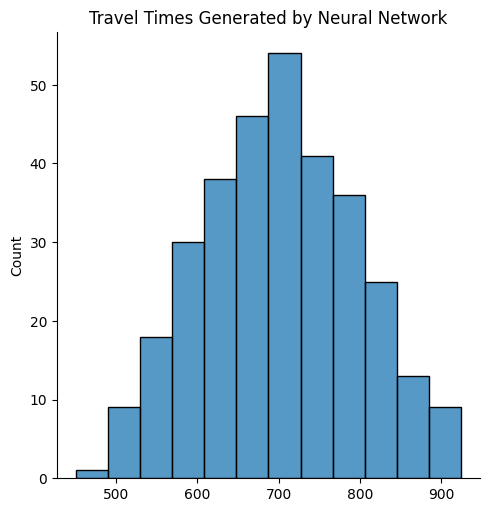

In [85]:
import seaborn as sns

testset = MyDataset(df_ts)
testloader = DataLoader(testset)
preds = []
with torch.no_grad():
    for data in testloader:
        features, labels = data
        # calculate outputs by running images through the network
        output = net(features)
        preds.append(output.item())

# preds = [630] * 320
# print(preds)
ids = testset.df["TRIP_ID"]
print(preds)
d = {"TRIP_ID" : ids, "TRAVEL_TIME" : preds}
newdf = pd.DataFrame(d)
print(newdf)
newdf.to_csv("100epochHighDropout.csv", index=None)
labels = preds
# print(labels)
print('mean', np.mean(labels))
print('std', np.std(labels))
print('median', np.median(labels))
print('min', np.min(labels))
print('max', np.max(labels))
print('----------')
sns.displot(labels).set(title='Travel Times Generated by Neural Network')
#Try to include all the stats in your kaggle submissions and save the image / send to discord

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


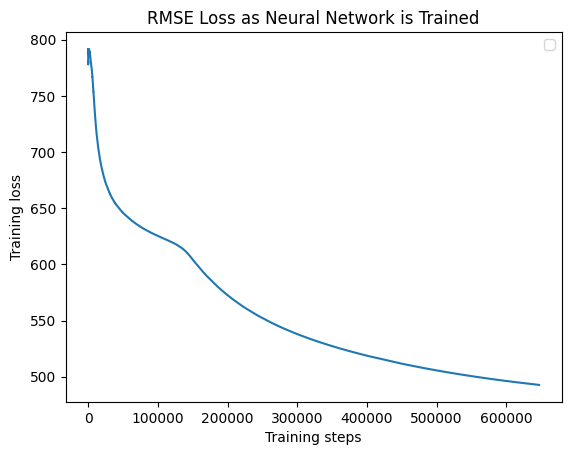

In [78]:
xRange = range(1, len(losses) + 1)

plt.plot(xRange, losses)

plt.xlabel("Training steps")
plt.ylabel("Training loss")
plt.title("RMSE Loss as Neural Network is Trained")
plt.legend()
plt.show()

tensor([[0.0000e+00, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.0200e+03],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.0280e+03],
        [0.0000e+00, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.0220e+03],
        ...,
        [0.0000e+00, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         9.9600e+02],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         5.0300e+02],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         7.5900e+02]])

In [78]:
import ast
net.eval()
# Create a list to store the losses
data_point_losses = []

# Iterate over the dataset and compute the losses
with torch.no_grad():
    print(trds.df.shape)
    for i in range(trds.df.shape[0]):
        if i % 100000 == 0:
            print("i: ", i)
        # print(trds.df[i:i+1])
        input = trds.x_train[i]
        output = net(input)
        label = trds.y_train[i]
        # print(input)
        # print('output: ', output.item())
        # print('label: ', label.item())
        # print('loss: ', criterion(output.item(), label).item())
        loss = criterion(output, label)
        data_point_losses.append(loss.item())  # Append the loss value to the list

# Convert the losses to a tensor
loss_tensor = torch.tensor(data_point_losses)


(1656255, 142)
i:  0
i:  100000
i:  200000
i:  300000
i:  400000
i:  500000
i:  600000
i:  700000
i:  800000
i:  900000
i:  1000000
i:  1100000
i:  1200000
i:  1300000
i:  1400000
i:  1500000
i:  1600000


[[-8.669106, 41.235093], [-8.669178, 41.236551], [-8.669385, 41.238252], [-8.668089, 41.237118], [-8.667459, 41.234994], [-8.666766, 41.232825], [-8.667801, 41.230773], [-8.66853, 41.228127], [-8.669052, 41.225679], [-8.667945, 41.224293], [-8.665596, 41.225652], [-8.661996, 41.225841], [-8.658108, 41.226984], [-8.654913, 41.229216], [-8.653293, 41.23233], [-8.653563, 41.236083], [-8.650467, 41.239143], [-8.646075, 41.240898], [-8.640945, 41.239827], [-8.635563, 41.239629], [-8.630613, 41.241096], [-8.625447, 41.241474], [-8.619714, 41.240142], [-8.613387, 41.239323], [-8.606727, 41.239998], [-8.600049, 41.23962], [-8.593884, 41.237766], [-8.587503, 41.237784], [-8.581401, 41.239008], [-8.575209, 41.239314], [-8.56998, 41.240178], [-8.56773, 41.240475], [-8.567631, 41.240349], [-8.565012, 41.239539], [-8.562465, 41.2407], [-8.56413, 41.242572], [-8.565471, 41.245434], [-8.567442, 41.248683], [-8.568369, 41.253192], [-8.566992, 41.258025], [-8.564274, 41.262921], [-8.561628, 41.267637],

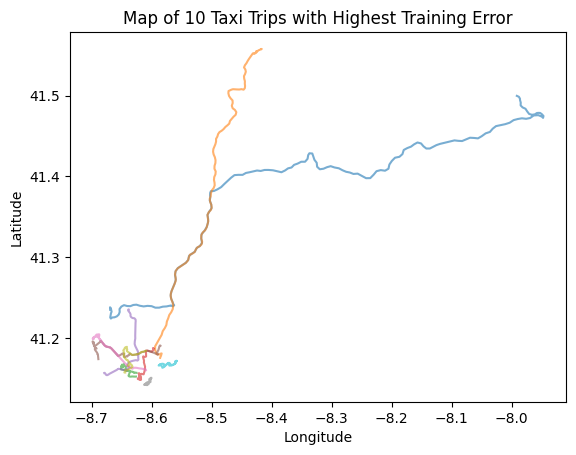

In [88]:
# Find the indices and values of the top 10 highest losses
top_loss_values, top_loss_indices = torch.topk(loss_tensor, k=10, largest=True)

# Print the indices and corresponding losses
for value, index in zip(top_loss_values, top_loss_indices):
    # print("Index:", index.item(), "Loss:", value.item())
    polyline = trds.df[index.item():index.item()+1]['POLYLINE'].values[0]
    polyline_array = ast.literal_eval(polyline)
    longitude_values = [row[0] for row in polyline_array]  # First column elements
    latitude_values = [row[1] for row in polyline_array]  # Second column elements
    print(polyline_array)
    plt.plot(longitude_values, latitude_values, label = str(index.item()), alpha=0.6)

    # print(x_vals)

# plt.plot()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
# plt.legend()
plt.title("Map of 10 Taxi Trips with Highest Training Error")
plt.show()



In [314]:
# with torch.no_grad():
#     total_loss = 0.0
#     for i, data in enumerate(val_loader, 0):

#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data


#         # forward + backward + optimize
#         labels=labels
#         outputs = net(inputs)
        
#         loss = criterion(outputs, labels)


#         # print statistics
#         total_loss += loss.item()
#         # if i%1000==0:
#         #     print(round(loss.item()), outputs, labels)

# print(f'Total Loss: {total_loss / len(val_loader):.3f}')


Total Loss: 635.196


[766.5413208007812, 667.6160888671875, 767.7797241210938, 634.6720581054688, 725.2482299804688, 712.5795288085938, 767.0057373046875, 707.9356079101562, 745.2899169921875, 769.1729736328125, 600.3084716796875, 731.551513671875, 731.0870971679688, 738.421142578125, 732.9447021484375, 734.6474609375, 731.8611450195312, 733.4090576171875, 767.3152465820312, 737.124267578125, 766.3865966796875, 707.7808837890625, 709.622802734375, 766.2317504882812, 658.4505004882812, 732.4895629882812, 767.0057373046875, 766.2317504882812, 636.6326293945312, 767.6249389648438, 767.9345092773438, 667.1516723632812, 732.3255004882812, 730.9323120117188, 732.7899169921875, 736.9694213867188, 864.7465209960938, 594.0904541015625, 766.3865966796875, 648.3621215820312, 633.3643798828125, 731.0870971679688, 732.3255004882812, 745.9091796875, 626.0264282226562, 631.1588745117188, 732.015869140625, 731.551513671875, 572.9459838867188, 600.1536254882812, 621.6449584960938, 678.3794555664062, 593.7809448242188, 767.

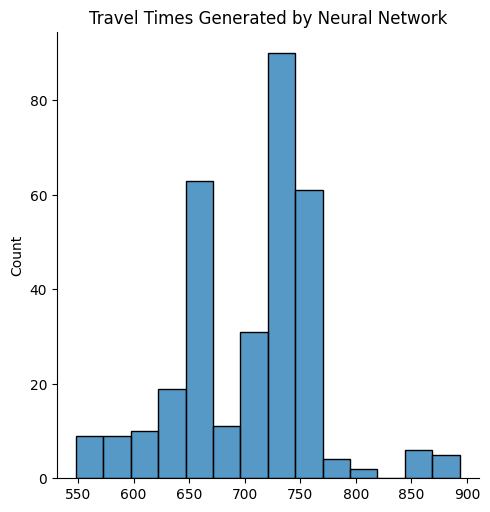

In [316]:
# # Sample submission file that is given on kaggle
# df_sample = pd.read_csv("archive/sampleSubmission.csv")

# df_sample["TRAVEL_TIME"] = 716.43

# # mean(716.43) -> 792.73593
# # median(600) -> 784.74219
# df_sample.to_csv("my_pred.csv", index=None)

**Boosted Decision Trees**


In [98]:
def processCSV(csvname):
  xg_train = pd.read_csv(csvname)
  df_tr = xg_train
  if "POLYLINE" not in df_tr: #test dataset
    df_tr["POLYLINE"]="[[["
    df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)
  else: 
    df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)
    mean, std = df_tr["LEN"].mean(), df_tr["LEN"].std()
    median = df_tr["LEN"].median()
    outlier_threshold = 3
    print(mean, std)
    df_trimmed = df_tr[df_tr["LEN"] < mean + outlier_threshold * std]
    df_trimmed = df_trimmed[df_trimmed['MISSING_DATA'] == False]
    print("Before Trimming: " + str(len(df_tr)))
    print("After Trimming: " + str(len(df_trimmed)))
    df_tr = df_trimmed
    # first trim the dataset

  df_tr[["YR", "MON", "DAY", "HR", "WK", "DAYOFYEAR"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
  df_tr["MIDMINS"] = df_tr[["TIMESTAMP"]].apply(parse_midnight_minutes, axis=1, result_type="expand")
  
  LetterToIndex = {'A': 0, 'B': 1, 'C': 2}
  df_trimmed_copy = df_tr
  # print('there was ' + str(len(df_trimmed_copy['LEN'] == 0)) + " zeroes")
  # df_trimmed_copy = df_trimmed_copy[df_trimmed_copy['LEN'] != 0]
  y_train = df_trimmed_copy["LEN"]
  df_trimmed_copy["CALL_TYPE"] = df_trimmed_copy["CALL_TYPE"].map(LetterToIndex)
  # df_trimmed_copy["DAY_TYPE"] = df_trimmed_copy["DAY_TYPE"].map(LetterToIndex)
  #took out "TRIP_ID"
  # x_train = df_trimmed_copy[["TRIP_ID", "CALL_TYPE", "ORIGIN_CALL", "ORIGIN_STAND", "TAXI_ID", "YR", "MON", "DAY", "HR", "WK", "MIDMINS"]]
  return df_trimmed_copy, y_train

In [99]:
x_train_unfiltered, y_train = processCSV('archive/train.csv')

716.4264615618442 684.7511617508213
Before Trimming: 1710670
After Trimming: 1692763


In [73]:
with pd.option_context('display.max_rows', 999):
    a = x_train_unfiltered['DAYOFYEAR']
    vals = a.value_counts()
    total = 0
    for val in vals:
        total += val
    print('total ', total)
    print(a.shape)
    for val, cnt in vals.items():
        print(val, cnt, cnt/total)
    # print(vals)


total  1692763
(1692763,)
174 8443 0.004987703535580586
365 8273 0.0048872760096953915
157 8018 0.004736634720867599
354 7956 0.004700008211427117
129 7359 0.004347330370524403
123 7092 0.004189600079869421
270 7028 0.004151792070124406
305 6961 0.0041122118099225944
158 6958 0.004110439559465796
330 6898 0.004074994550329845
277 6894 0.004072631549720782
284 6827 0.00403305128951897
45 6783 0.004007058282819272
59 6766 0.003997015530230753
340 6720 0.003969841023226524
186 6719 0.003969250273074258
150 6693 0.003953890769115346
263 6682 0.003947392517440421
114 6582 0.003888317502213836
347 6560 0.0038753209988639874
151 6519 0.0038511002426210874
171 6491 0.0038345592383576435
52 6490 0.0038339684882053777
257 6483 0.0038298332371395167
355 6480 0.0038280609866827194
143 6450 0.003810338482114744
298 6446 0.0038079754815056803
87 6442 0.003805612480896617
126 6423 0.0037943882280035658
120 6410 0.0037867084760241096
256 6396 0.0037784379738923877
156 6385 0.0037719397222174635
178 63

In [83]:
a = max(x_train_unfiltered[x_train_unfiltered['DAYOFYEAR'] == 1]['LEN'])
print(a)
days = range(1, 366)
weekdays= range(0, 7)


dayvals = []
for day in days:
    dayvals.append(np.mean(x_train_unfiltered[x_train_unfiltered['DAYOFYEAR'] == day]['LEN']))


2760


In [101]:
taxiIdValues = x_train_unfiltered['TAXI_ID'].value_counts()
taxiMin = min(x_train_unfiltered['TAXI_ID'])

x_axis_id_minus = []
y_axis_avg_len = []
for val, cnt in taxiIdValues.items():
    x_axis_id_minus.append(val - taxiMin)
    y_axis_avg_len.append(np.mean(x_train_unfiltered[x_train_unfiltered['TAXI_ID'] == val]['LEN']))


In [107]:
# taxiIdValues = x_train_unfiltered['TAXI_ID'].value_counts()

with pd.option_context('display.max_rows', 999):
    a = x_train_unfiltered['TAXI_ID']
    vals = a.value_counts()
    total = 0
    for val in vals:
        total += val
    print('total ', total)
    print(a.shape)
    for val, cnt in vals.items():
        print(val, cnt, cnt/total)

total  1692763
(1692763,)
20000080 10742 0.006345838135639779
20000403 9160 0.005411271394755202
20000066 8411 0.004968799530708079
20000364 7788 0.004600762185846453
20000483 7704 0.004551139173056122
20000129 7552 0.004461345149911713
20000307 7426 0.004386910630726215
20000621 7246 0.004280575603318361
20000089 7246 0.004280575603318361
20000424 7152 0.004225045089005372
20000492 7132 0.004213230085960054
20000616 6822 0.004030097538757641
20000529 6820 0.004028916038453109
20000678 6496 0.003837512989118973
20000304 6478 0.0038268794863781878
20000325 6427 0.0037967512286126294
20000042 6422 0.0037937974778513
20000263 6371 0.0037636692200857416
20000235 6367 0.003761306219476678
20000179 6351 0.0037518542170404245
20000372 6334 0.003741811464451905
20000140 6285 0.0037128647069908783
20000233 6278 0.0037087294559250174
20000450 6270 0.0037040034547068906
20000171 6221 0.003675056697245864
20000686 6195 0.0036596971932869515
20000367 6164 0.0036413839385667102
20000648 6150 0.00363

In [108]:
# taxiIdValues = x_train_unfiltered[x_train_unfiltered['LEN'] == 0]['TAXI_ID'].value_counts()
with pd.option_context('display.max_rows', 999):
    a = x_train_unfiltered[x_train_unfiltered['LEN'] == 0]['TAXI_ID']
    vals = a.value_counts()
    total = 0
    for val in vals:
        total += val
    print('total ', total)
    print(a.shape)
    for val, cnt in vals.items():
        print(val, cnt, cnt/total)

total  36508
(36508,)
20000080 5535 0.15161060589459843
20000066 1692 0.046346006354771555
20000403 1385 0.037936890544538186
20000663 834 0.022844308096855483
20000196 527 0.014435192286622111
20000099 505 0.013832584638983236
20000129 456 0.0124904130601512
20000026 441 0.01207954420948833
20000286 412 0.011285197764873453
20000295 395 0.010819546400788868
20000364 391 0.010709981373945437
20000167 387 0.010600416347102005
20000616 343 0.009395201051824257
20000273 330 0.009039114714583105
20000901 299 0.00818998575654651
20000680 282 0.007724334392461926
20000072 280 0.0076695518790402106
20000455 280 0.0076695518790402106
20000372 270 0.007395639311931631
20000089 259 0.007094335488112195
20000496 258 0.007066944231401337
20000463 257 0.007039552974690479
20000319 254 0.006957379204557905
20000524 235 0.006436945327051605
20000618 233 0.006382162813629889
20000513 229 0.006272597786786458
20000640 211 0.005779555165991016
20000571 211 0.005779555165991016
20000243 200 0.00547825134

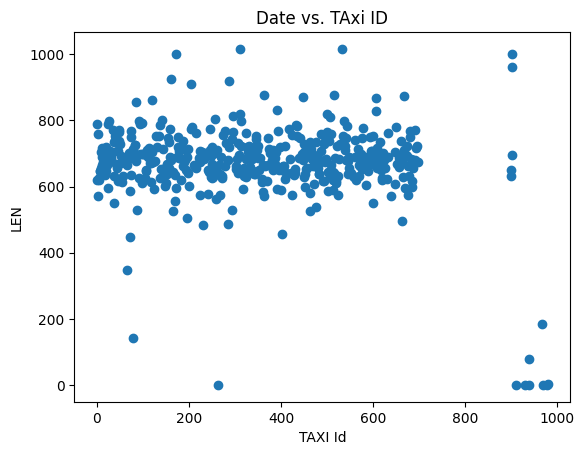

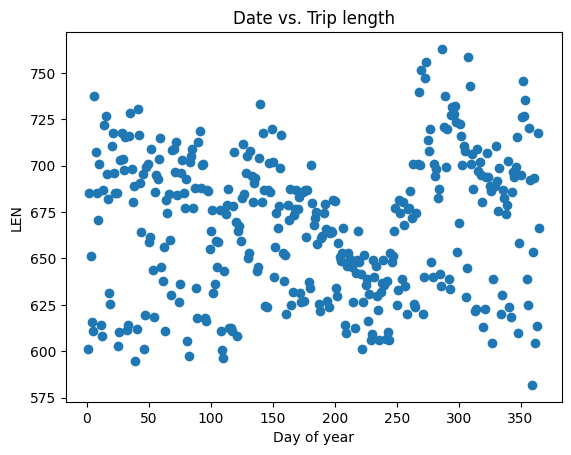

In [102]:

plt.scatter(x_axis_id_minus, y_axis_avg_len)
plt.xlabel('TAXI Id')
plt.ylabel('LEN')
plt.title('Date vs. TAxi ID')

# Display the plot
plt.show()
# Create a scatter plot
plt.scatter(days, dayvals)
plt.xlabel('Day of year')
plt.ylabel('LEN')
plt.title('Date vs. Trip length')

# Display the plot
plt.show()

In [86]:
x_train = x_train_unfiltered[["TRIP_ID", "CALL_TYPE", "ORIGIN_CALL", "ORIGIN_STAND", "TAXI_ID", "YR", "MON", "HR", "WK", "DAYOFYEAR", "MIDMINS"]]

In [87]:
x_train.drop(columns=['TRIP_ID'])#this doesnt actually drop, just without tripid

,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,YR,MON,HR,WK,DAYOFYEAR,MIDMINS
0,C,NaN,NaN,20000589,2013,6,17,6,181,1020.000000
1,B,NaN,7.0,20000596,2013,6,17,6,181,1020.005556
2,C,NaN,NaN,20000320,2013,6,17,6,181,1020.001389
3,C,NaN,NaN,20000520,2013,6,17,6,181,1020.000000
4,C,NaN,NaN,20000337,2013,6,17,6,181,1020.002778
...,...,...,...,...,...,...,...,...,...,...
1710665,C,NaN,NaN,20000698,2014,6,16,0,181,960.025694
1710666,C,NaN,NaN,20000670,2014,6,16,0,181,960.025000
1710667,C,NaN,NaN,20000264,2014,1,2,4,3,120.028472
1710668,B,NaN,12.0,20000248,2014,6,8,0,181,480.015972


In [88]:
y_train

0          330
1          270
2          960
3          630
4          420
          ... 
1710665    465
1710666    435
1710667      0
1710668    915
1710669    390
Name: LEN, Length: 1692763, dtype: int64

In [95]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# shuffle_indices = np.random.permutation(len(x_train))
# X_shuffled = x_train[shuffle_indices]
# y_shuffled = y_train[shuffle_indices]

combined_df = pd.concat([x_train, y_train], axis=1)

# Get the number of rows in the DataFrame
num_rows = combined_df.shape[0]

# Generate a random permutation of indices
perm = np.random.permutation(num_rows)

# Shuffle the combined DataFrame using the permutation
shuffled_df = combined_df.iloc[perm]

# Split the shuffled DataFrame back into separate DataFrames
shuffled_train_df = shuffled_df.iloc[:, :-1]
shuffled_label_df = shuffled_df.iloc[:, -1]

X_train, X_val, Y_train, Y_val = train_test_split(shuffled_train_df, shuffled_label_df, test_size=0.2, random_state=None)

# Assuming you have a DataFrame called 'df' with features and target variables

# Convert DataFrame to DMatrix
feature_types = ['c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'q']

data_matrix = xgb.DMatrix(data = X_train.drop(columns=['TRIP_ID']), label=Y_train, feature_types=feature_types, enable_categorical=True)
validation_matrix = xgb.DMatrix(data = X_val.drop(columns=['TRIP_ID']), label=Y_val, feature_types=feature_types, enable_categorical=True)

parameters = {
    'objective': 'reg:squarederror',
    # 'colsample_bytree': 0.5586586280723452,
    # 'learning_rate': 0.06889888561468978,
    'max_depth': 6,
    # 'n_estimators': 1164,
    # 'reg_alpha': 25.287638310615133,
    # 'reg_lambda': 67.51702941180568,
    # 'subsample': 0.77179392553171
}

xg_model = xgb.train(parameters, data_matrix, num_boost_round=5000, early_stopping_rounds=10, evals=[(validation_matrix, 'validation')], verbose_eval=10)

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:CALL_TYPE: object

In [91]:
test_x, test_y = processCSV('archive/test_public.csv')
test_x = test_x.drop(columns=["DAY_TYPE", "MISSING_DATA", 'POLYLINE', 'LEN', 'TIMESTAMP', 'DAY'])
test_x

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,YR,MON,HR,WK,DAYOFYEAR,MIDMINS
0,T1,B,NaN,15.0,20000542,2014,8,10,3,226,600.039583
1,T2,B,NaN,57.0,20000108,2014,8,10,3,226,600.034722
2,T3,B,NaN,15.0,20000370,2014,8,10,3,226,600.034028
3,T4,B,NaN,53.0,20000492,2014,8,10,3,226,600.040278
4,T5,B,NaN,18.0,20000621,2014,8,10,3,226,600.040972
...,...,...,...,...,...,...,...,...,...,...,...
315,T323,A,70885.0,NaN,20000430,2014,12,6,6,355,360.012500
316,T324,B,NaN,53.0,20000020,2014,12,6,6,355,360.004167
317,T325,C,NaN,NaN,20000207,2014,12,6,6,355,360.019444
318,T326,A,76232.0,NaN,20000667,2014,12,6,6,355,360.018056


In [133]:
y_pred = xg_model.predict(xgb.DMatrix(test_x.drop(columns=['TRIP_ID'])), enable_categorical=True)
# y_pred

mean 681.43036
std 142.55025
median 681.061
min 42.21386
max 1135.8921
----------


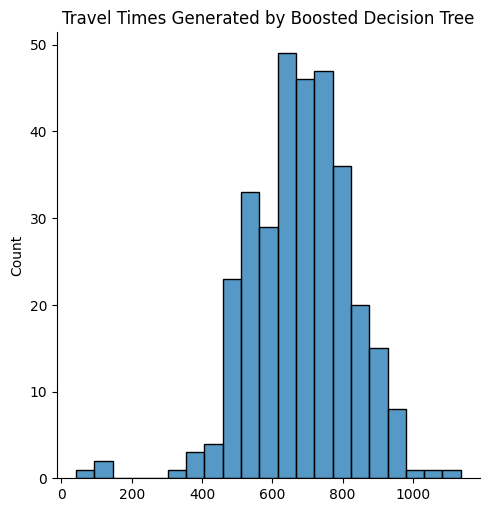

In [134]:
import seaborn as sns
ids = test_x["TRIP_ID"].values
# print(ids)
for i in range(len(y_pred)):
    y_pred[i] = y_pred[i]
d = {"TRIP_ID" : ids, "TRAVEL_TIME" : y_pred}
newdf = pd.DataFrame(d)
# print(newdf)
newdf.to_csv("another_tree_max_depth3.csv", index=None)
labels = y_pred
# print(labels)
print('mean', np.mean(labels))
print('std', np.std(labels))
print('median', np.median(labels))
print('min', np.min(labels))
print('max', np.max(labels))
print('----------')
sns.displot(labels).set(title='Travel Times Generated by Boosted Decision Tree')



### Do some Feature Analysis

For our feature analysis, we are looking at which of our engineered features may be useful in making a taxicab time regression model

Using: 1656255/1656255


KeyError: ['YR']

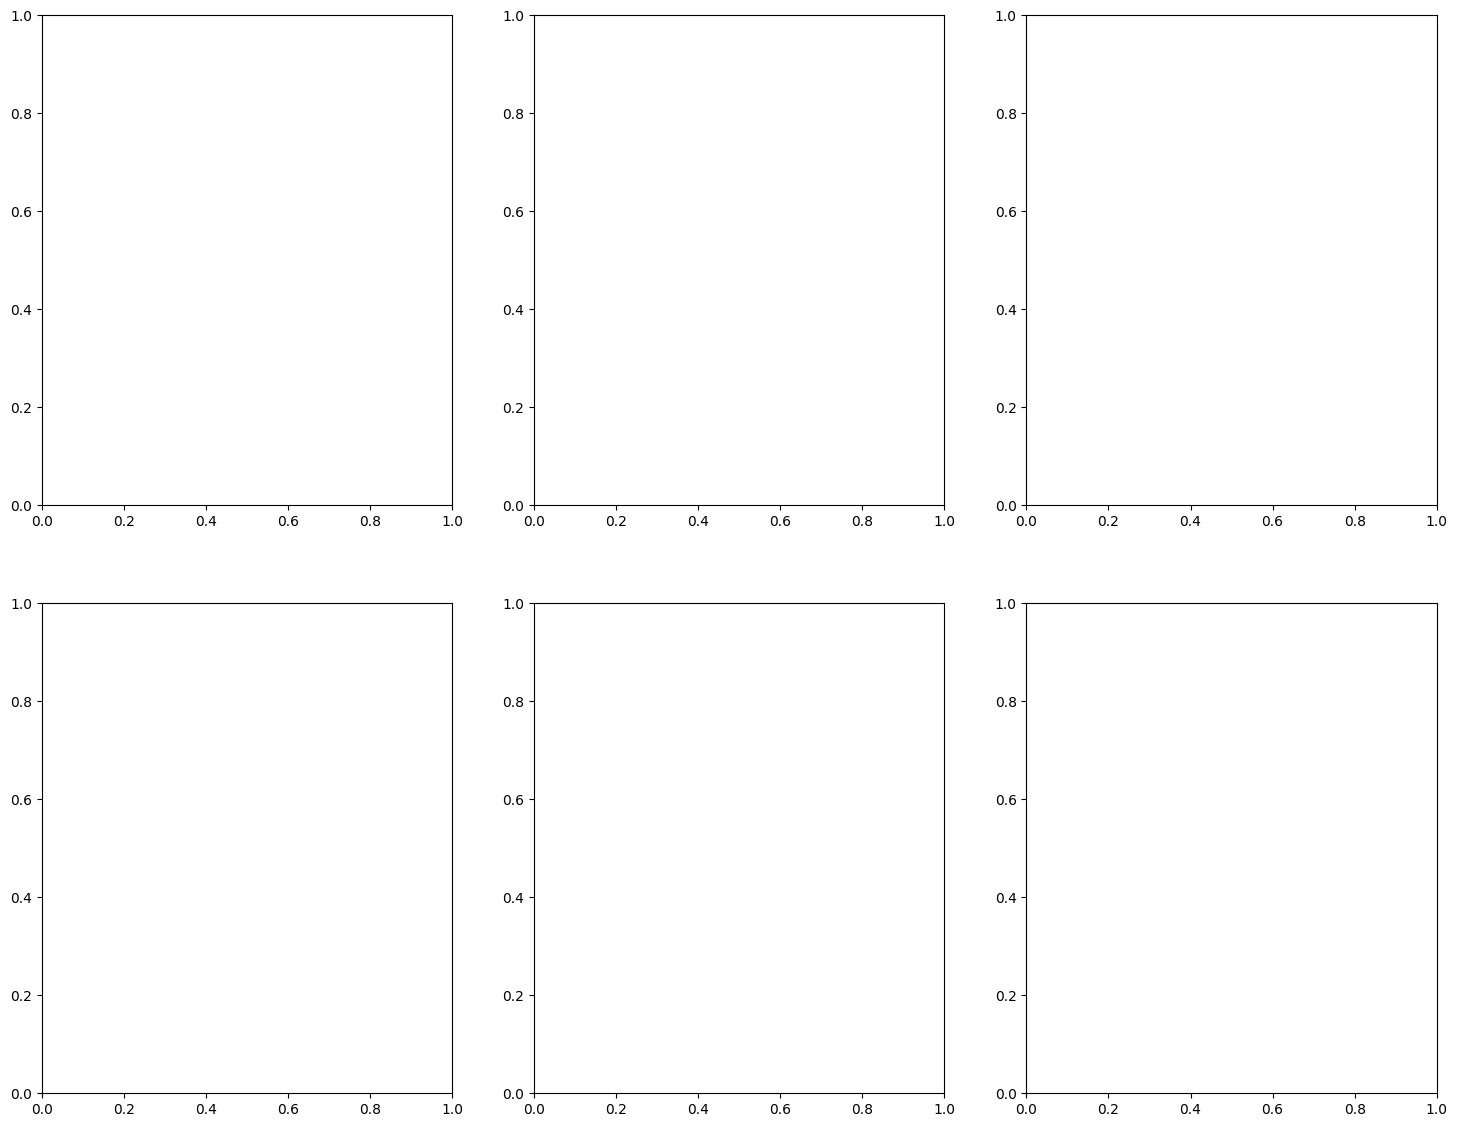

In [90]:
# First n samples to analyze. Set to -1 to use all data
end = -1

outlier_threshold = 3

# "Choose all data, where the trip length is less than 3 standard deviations away from the mean"
# This is to remove outliers. Otherwise, our plots would look very squished (since there are some
# VERRRRRY long taxi trips in the dataset)
df_trimmed = df_tr[df_tr["LEN"] < mean + outlier_threshold * std]

# Because our y-values only take on multiples of 15, we want just enough buckets in a histogram
# such that each buckets counts one value's frequency. (e.x. one bucket counts how many 15s trips, 
# how many 30s trips, etc. )
buckets = (int(mean + outlier_threshold * std) // 15)

print(f"Using: {len(df_trimmed)}/{len(df_tr)}")

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,14))

# Now, we visualize some features that we think might be useful
for idx, v in enumerate(["YR", "MON", "DAY", "HR", "WK", "ORIGIN_STAND"]):
  # idx // 3 = row, idx % 3 = column
  ax = axs[idx // 3, idx % 3]
  
  # Remove any rows with invalid values
  df_subset = df_trimmed.dropna(subset=v)
  
  # Create a histogram. Look up the documentation for more details
  ax.hist2d(df_subset[v][:end], df_subset["LEN"][:end], cmap="CMRmap", bins=(120,buckets))
  
  # Some stylistic things to make the graphs look nice
  ax.set_xlim(ax.get_xlim()[0] - 1, ax.get_xlim()[1] + 1)
  ax.set_facecolor("black")
  ax.set_ylabel("seconds", fontsize=18)
  ax.set_title(f"Feature: {v}", fontsize=20)


In [ ]:
plt.figure(figsize=(10,10))
for v in [0, 5, 11, 17, 23]:
  # Filter data where the HR matches v
  hourly_data = df_trimmed[df_trimmed["HR"] == v]["LEN"]
  histogram, bin_boundary = np.histogram(hourly_data, bins=buckets)
  histogram = histogram / len(hourly_data)
  # The center is the left_bound and right_bound of a bucket
  bin_centers = [(bin_boundary[i] + bin_boundary[i + 1]) / 2 for i in range(buckets)]
  plt.plot(bin_centers, histogram, label=f"HR={v}")
plt.legend();